In [2]:
import numpy as np
from sklearn.datasets import load_wine, fetch_openml, fetch_20newsgroups, fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt # Added for plotting

# 1. SVD Implementation from Scratch
def svd_from_scratch(A):
    with tqdm(total=3, desc="SVD Computation (Scratch)") as pbar:
        ATA = np.dot(A.T, A)
        AAT = np.dot(A, A.T)
        pbar.update(1)
        
        eigvals_V, V = np.linalg.eigh(ATA)
        eigvals_U, U = np.linalg.eigh(AAT)
        pbar.update(1)
        
        idx_V = eigvals_V.argsort()[::-1]
        eigvals_V = eigvals_V[idx_V]
        V = V[:, idx_V]
        
        idx_U = eigvals_U.argsort()[::-1]
        eigvals_U = eigvals_U[idx_U]
        U = U[:, idx_U]
        
        singular_values = np.sqrt(np.abs(eigvals_V))
        singular_values = np.sort(singular_values)[::-1]
        
        diag_len = min(A.shape[0], A.shape[1])
        Sigma_diag = singular_values[:diag_len] # 1D array of singular values

        U_final = U[:, :diag_len]
        Vt_final = V.T[:diag_len, :] # This Vt needs to be constructed carefully
                                     # V are eigenvectors of A.T @ A. V.T needs to be (k, n_features)
                                     # V from eigh(ATA) is (n_features, n_features)
                                     # Vt_final should be V.T (all rows of V.T, truncated to diag_len columns if M < N)
                                     # Or rather, Vt are the first 'diag_len' rows of the full V.T
        # A more standard way:
        # V comes from ATA. The columns of V are the right singular vectors.
        # Vt = V.T
        # singular_values are sqrt of eigenvalues of ATA (or AAT)
        
        # For the purpose of this function returning U, S_1D, Vt
        # Let S_1D be the sorted singular values.
        # U should be the corresponding left singular vectors
        # Vt should be the corresponding right singular vectors (transposed)
        pbar.update(1)
    # This scratch SVD is complex to get perfectly aligned with np.linalg.svd especially for non-square A
    # For now, we return what's calculated, but np.linalg.svd is used for most critical parts.
    # The crucial part is Vt for the transformation matrix.
    return U_final, Sigma_diag, V.T # V.T from eigh(ATA) is the correct Vt

# 2. EVD Implementation from Scratch (for covariance matrix)
def evd_from_scratch(A):
    with tqdm(total=2, desc="EVD Computation") as pbar:
        cov_matrix = np.cov(A.T)
        pbar.update(1)
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)
        idx = eigvals.argsort()[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        pbar.update(1)
    return eigvals, eigvecs

# 3. Get Transformation Matrices with Variance Retention
def get_svd_transform_matrix(X, variance_retained=0.95, use_linalg_svd=False):
    singular_values = None
    Vt = None
    if use_linalg_svd:
        with tqdm(total=1, desc="SVD Computation (linalg.svd)") as pbar:
            try:
                U, s, Vt = np.linalg.svd(X, full_matrices=False)
                singular_values = s
            except np.linalg.LinAlgError as e:
                print(f"SVD computation failed: {e}. Skipping SVD for this dataset.")
                return None
            pbar.update(1)
    else:
        U_scratch, s_scratch, Vt_scratch = svd_from_scratch(X) # s_scratch is 1D
        singular_values = s_scratch
        Vt = Vt_scratch
    
    if singular_values is None or Vt is None:
        print("SVD: Singular values or Vt not computed.")
        return None

    variance_explained = singular_values**2 / np.sum(singular_values**2)
    cumulative_variance = np.cumsum(variance_explained)
    
    k_candidates = np.where(cumulative_variance >= variance_retained)[0]
    if len(k_candidates) == 0:
        k = len(singular_values)
    else:
        k = k_candidates[0] + 1
    
    transform_matrix = Vt.T[:, :k]
    
    actual_variance_retained = cumulative_variance[k-1] if k > 0 and k <= len(cumulative_variance) else (cumulative_variance[-1] if len(cumulative_variance) > 0 else 0.0)
    print(f"SVD: Selected {k} components retaining {actual_variance_retained:.4f} variance.")
    return transform_matrix

def get_evd_transform_matrix(X, variance_retained=0.95):
    eigvals, eigvecs = evd_from_scratch(X)
    total_variance = np.sum(eigvals)
    if total_variance == 0:
        print("EVD: Total variance is zero. Cannot determine components.")
        return eigvecs[:, :min(1, eigvecs.shape[1])] # return at least one component or empty if no eigvecs

    cumulative_variance = np.cumsum(eigvals) / total_variance
    k_candidates = np.where(cumulative_variance >= variance_retained)[0]
    if len(k_candidates) == 0:
        k = len(eigvals)
    else:
        k = k_candidates[0] + 1
            
    transform_matrix = eigvecs[:, :k]
    actual_variance_retained = cumulative_variance[k-1] if k > 0 and k <= len(cumulative_variance) else (cumulative_variance[-1] if len(cumulative_variance) > 0 else 0.0)
    print(f"EVD: Selected {k} components retaining {actual_variance_retained:.4f} variance.")
    return transform_matrix



In [3]:
# 4. Load and Preprocess Datasets
def load_and_preprocess_data():
    print("Loading and Preprocessing Sensorless, Wine, MNIST Datasets...")
    X_sensor_train, X_sensor_test, y_sensor_train, y_sensor_test = None, None, None, None
    X_wine_train, X_wine_test, y_wine_train, y_wine_test = None, None, None, None
    X_mnist_train, X_mnist_test, y_mnist_train_all, y_mnist_test_labels = None, None, None, None # Renamed y_mnist_test

    with tqdm(total=6, desc="Data Preprocessing (S/W/M)") as pbar:
        try:
            data = np.loadtxt("Sensorless_drive_diagnosis.txt", delimiter=' ')
            X_sensor = data[:, :-1]
            y_sensor = data[:, -1] - 1
            scaler_sensor = StandardScaler()
            X_sensor = scaler_sensor.fit_transform(X_sensor)
            X_sensor_train, X_sensor_test, y_sensor_train, y_sensor_test = train_test_split(
                X_sensor, y_sensor, test_size=0.2, random_state=42, stratify=y_sensor)
        except FileNotFoundError:
            print("Sensorless_drive_diagnosis.txt not found. Skipping Sensorless dataset.")
        except Exception as e:
            print(f"Error loading Sensorless dataset: {e}. Skipping.")
        pbar.update(1)
        
        try:
            wine = load_wine()
            X_wine = wine.data
            y_wine = wine.target
            scaler_wine = StandardScaler()
            X_wine = scaler_wine.fit_transform(X_wine)
            X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(
                X_wine, y_wine, test_size=0.2, random_state=42, stratify=y_wine)
        except Exception as e:
            print(f"Error loading Wine dataset: {e}. Skipping.")
        pbar.update(1)
        
        try:
            mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
            X_mnist = mnist.data
            y_mnist = mnist.target.astype(int)
            X_mnist_train_all_samples = X_mnist[:60000]
            y_mnist_train_all = y_mnist[:60000] # y_mnist_train_all for training
            X_mnist_test_samples = X_mnist[60000:]
            y_mnist_test_labels = y_mnist[60000:] # y_mnist_test_labels for ground truth
            
            scaler_mnist = StandardScaler()
            X_mnist_train = scaler_mnist.fit_transform(X_mnist_train_all_samples)
            X_mnist_test = scaler_mnist.transform(X_mnist_test_samples) # X_mnist_test for model input
        except Exception as e:
            print(f"Failed to load MNIST: {e}. Skipping MNIST dataset.")
        pbar.update(4)
    
    return (X_sensor_train, X_sensor_test, y_sensor_train, y_sensor_test), \
           (X_wine_train, X_wine_test, y_wine_train, y_wine_test), \
           (X_mnist_train, X_mnist_test, y_mnist_train_all, y_mnist_test_labels)

def load_and_preprocess_newsgroups():
    try:
        print("Loading and Preprocessing 20 Newsgroups Dataset...")
        with tqdm(total=3, desc="Newsgroups Preprocessing") as pbar:
            newsgroups_train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
            newsgroups_test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
            pbar.update(1)
            vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
            X_news_train = vectorizer.fit_transform(newsgroups_train_data.data).toarray()
            y_news_train = newsgroups_train_data.target
            pbar.update(1)
            X_news_test = vectorizer.transform(newsgroups_test_data.data).toarray()
            y_news_test = newsgroups_test_data.target
            pbar.update(1)
        return X_news_train, X_news_test, y_news_train, y_news_test
    except Exception as e:
        print(f"Failed to load 20 Newsgroups: {e}. Skipping Newsgroups dataset.")
        return None, None, None, None

def load_and_preprocess_covtype(test_size=0.2, random_state=42):
    try:
        print("Loading and Preprocessing Covertype Dataset...")
        with tqdm(total=4, desc="Covertype Preprocessing") as pbar:
            covtype = fetch_covtype()
            X = covtype.data
            y = covtype.target - 1
            pbar.update(1)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=random_state, stratify=y)
            pbar.update(1)
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            pbar.update(1)
            X_test = scaler.transform(X_test)
            pbar.update(1)
        return X_train, X_test, y_train, y_test
    except Exception as e:
        print(f"Failed to load Covertype: {e}. Skipping Covertype dataset.")
        return None, None, None, None



In [4]:
# 5. Train and Evaluate KNN
def train_knn(X_train, X_test, y_train, y_test, label):
    if X_train is None or y_train is None or X_train.shape[0] == 0:
        print(f"Skipping KNN for {label} due to missing/empty training data.")
        return 0.0
    if X_test is None or y_test is None or X_test.shape[0] == 0 :
        print(f"Skipping KNN for {label} due to missing/empty test data.")
        # Can't compute accuracy, but model could still be trained.
        # For this script's purpose, if test data is missing, skip.
        return 0.0
        
    knn = KNeighborsClassifier(n_neighbors=min(5, X_train.shape[0]))
    with tqdm(total=2, desc=f"KNN Training ({label})") as pbar:
        start_time = time.time()
        knn.fit(X_train, y_train)
        train_time = time.time() - start_time
        pbar.update(1)
        accuracy = 0.0
        inference_time = 0.0
        if X_test is not None and y_test is not None and X_test.shape[0] > 0:
             start_time = time.time()
             accuracy = knn.score(X_test, y_test)
             inference_time = time.time() - start_time
        pbar.update(1)
    
    print(f"{label} - Features: {X_train.shape[1]}, Accuracy: {accuracy:.4f}, "
          f"Training Time: {train_time:.2f}s, Inference Time: {inference_time:.2f}s")
    return accuracy # Model itself isn't returned here, but could be if needed



In [5]:
# 6. Neural Network Definition (PyTorch)
class ClassifierNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ClassifierNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# 7. Train and Evaluate Neural Network (MODIFIED TO RETURN MODEL)
def train_neural_network(X_train, X_test, y_train, y_test, label, output_dim, epochs=10):
    if X_train is None or y_train is None or X_train.shape[0] == 0 or X_train.shape[1] == 0:
        print(f"Skipping NN for {label} due to missing/empty/zero-feature training data.")
        return None, 0.0
    
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    
    batch_size = 32 if X_train.shape[0] < 100000 else 128 
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model = ClassifierNet(input_dim=X_train.shape[1], output_dim=output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    start_time = time.time()
    model.train()
    for epoch in tqdm(range(epochs), desc=f"NN Training ({label}) - E{epochs} B{batch_size}"):
        for data, target_batch in train_loader: # Renamed target to target_batch
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target_batch)
            loss.backward()
            optimizer.step()
    train_time = time.time() - start_time
    
    accuracy = 0.0
    inference_time = 0.0
    if X_test is not None and y_test is not None and X_test.shape[0] > 0:
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)
        model.eval()
        with tqdm(total=1, desc=f"NN Evaluation ({label})") as pbar:
            eval_start_time = time.time()
            with torch.no_grad():
                if X_test_tensor.shape[0] > 20000:
                    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
                    test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
                    correct_preds, total_preds = 0, 0
                    for data, target_batch in test_loader: # Renamed target to target_batch
                        output = model(data)
                        _, predicted = torch.max(output, 1)
                        correct_preds += (predicted == target_batch).sum().item()
                        total_preds += target_batch.size(0)
                    if total_preds > 0: accuracy = correct_preds / total_preds
                else:
                    output = model(X_test_tensor)
                    _, predicted = torch.max(output, 1)
                    accuracy = (predicted == y_test_tensor).float().mean().item()
            inference_time = time.time() - eval_start_time
            pbar.update(1)
    
    print(f"{label} - Features: {X_train.shape[1]}, Accuracy: {accuracy:.4f}, "
          f"Training Time: {train_time:.2f}s, Inference Time: {inference_time:.2f}s")
    return model, accuracy # Return the trained model and accuracy



In [6]:
# 8. Function to show MNIST predictions (NEW)
def show_mnist_predictions(images_scaled, true_labels, model_orig, model_svd, model_evd, V_svd_transform, eigvecs_evd_transform, num_images=6):
    if images_scaled is None or true_labels is None or \
       model_orig is None or model_svd is None or model_evd is None or \
       V_svd_transform is None or eigvecs_evd_transform is None:
        print("Cannot show MNIST predictions due to missing components.")
        return

    print("\nDisplaying MNIST Predictions...")
    
    # Select a few images
    sample_indices = np.random.choice(images_scaled.shape[0], num_images, replace=False)
    sample_images_scaled = images_scaled[sample_indices]
    sample_labels = true_labels[sample_indices]

    fig, axes = plt.subplots(2, (num_images + 1) // 2, figsize=(12, 7))
    axes = axes.flatten()

    model_orig.eval()
    model_svd.eval()
    model_evd.eval()

    for i in range(num_images):
        if i >= len(axes): break # Should not happen with current setup

        img_scaled = sample_images_scaled[i] # This is scaled and 1D (784,)
        
        # For display, reshape (original MNIST images are 28x28)
        # The scaler alters the range, but cmap='gray' will work.
        display_img = img_scaled.reshape(28, 28)
        
        # Predictions
        pred_orig, pred_svd, pred_evd = "N/A", "N/A", "N/A"

        with torch.no_grad():
            # Original model
            img_tensor_orig = torch.FloatTensor(img_scaled).unsqueeze(0)
            output_orig = model_orig(img_tensor_orig)
            pred_orig = torch.max(output_orig, 1)[1].item()

            # SVD model
            if V_svd_transform is not None:
                img_svd = img_scaled @ V_svd_transform
                img_tensor_svd = torch.FloatTensor(img_svd).unsqueeze(0)
                if img_tensor_svd.shape[1] == model_svd.fc1.in_features: # Check feature compatibility
                    output_svd = model_svd(img_tensor_svd)
                    pred_svd = torch.max(output_svd, 1)[1].item()
                else:
                    pred_svd = "Dim mismatch"


            # EVD model
            if eigvecs_evd_transform is not None:
                img_evd = img_scaled @ eigvecs_evd_transform
                img_tensor_evd = torch.FloatTensor(img_evd).unsqueeze(0)
                if img_tensor_evd.shape[1] == model_evd.fc1.in_features: # Check feature compatibility
                    output_evd = model_evd(img_tensor_evd)
                    pred_evd = torch.max(output_evd, 1)[1].item()
                else:
                    pred_evd = "Dim mismatch"

        ax = axes[i]
        ax.imshow(display_img, cmap='gray')
        ax.set_title(f"True: {sample_labels[i]}\nOrig: {pred_orig}, SVD: {pred_svd}, EVD: {pred_evd}", fontsize=9)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()




In [7]:
# 9. Main Execution (MODIFIED TO STORE MNIST MODELS AND CALL PLOTTING)

# Load datasets
(X_sensor_train, X_sensor_test, y_sensor_train, y_sensor_test), \
(X_wine_train, X_wine_test, y_wine_train, y_wine_test), \
(X_mnist_train, X_mnist_test_scaled, y_mnist_train, y_mnist_test_true_labels) = load_and_preprocess_data() # X_mnist_test is scaled

X_news_train, X_news_test, y_news_train, y_news_test = load_and_preprocess_newsgroups()
X_cov_train, X_cov_test, y_cov_train, y_cov_test = load_and_preprocess_covtype()

# --- Storage for MNIST specific models and transforms ---
mnist_components = {
    "model_orig": None, "model_svd": None, "model_evd": None,
    "V_svd_transform": None, "eigvecs_evd_transform": None,
    "X_test_scaled": X_mnist_test_scaled, # Scaled test features
    "y_test_true": y_mnist_test_true_labels   # True labels for test set
}

datasets_for_nn = []
if X_sensor_train is not None:
    datasets_for_nn.append({
        "name": "Sensorless", "X_train": X_sensor_train, "X_test": X_sensor_test, 
        "y_train": y_sensor_train, "y_test": y_sensor_test, "output_dim": 11, "use_linalg_svd": True
    })
if X_mnist_train is not None: # Check if MNIST data loaded
    datasets_for_nn.append({
        "name": "MNIST", "X_train": X_mnist_train, "X_test": X_mnist_test_scaled, # Use scaled test data
        "y_train": y_mnist_train, "y_test": y_mnist_test_true_labels, "output_dim": 10, "use_linalg_svd": True
    })
if X_news_train is not None:
        datasets_for_nn.append({
        "name": "Newsgroups", "X_train": X_news_train, "X_test": X_news_test,
        "y_train": y_news_train, "y_test": y_news_test, "output_dim": 20, "use_linalg_svd": True
    })
if X_cov_train is not None:
    datasets_for_nn.append({
        "name": "Covertype", "X_train": X_cov_train, "X_test": X_cov_test,
        "y_train": y_cov_train, "y_test": y_cov_test, "output_dim": 7, "use_linalg_svd": True
    })



Loading and Preprocessing Sensorless, Wine, MNIST Datasets...


Data Preprocessing (S/W/M): 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


Loading and Preprocessing 20 Newsgroups Dataset...


Newsgroups Preprocessing: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Loading and Preprocessing Covertype Dataset...


Covertype Preprocessing: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


## 95% variance

In [7]:
if X_wine_train is not None:
    print(f"\nWine Original Features: {X_wine_train.shape[1]}")
    V_wine_svd = get_svd_transform_matrix(X_wine_train, 0.95, use_linalg_svd=False)
    eigvecs_wine_evd = get_evd_transform_matrix(X_wine_train, 0.95)
    
    X_wine_train_svd, X_wine_test_svd = (X_wine_train @ V_wine_svd, X_wine_test @ V_wine_svd) if V_wine_svd is not None else (None, None)
    X_wine_train_evd, X_wine_test_evd = (X_wine_train @ eigvecs_wine_evd, X_wine_test @ eigvecs_wine_evd) if eigvecs_wine_evd is not None else (None, None)
    if X_wine_train_svd is not None: print(f"Wine SVD Reduced Features: {X_wine_train_svd.shape[1]}")
    if X_wine_train_evd is not None: print(f"Wine EVD Reduced Features: {X_wine_train_evd.shape[1]}")

    print("\nKNN Results on Wine Dataset:")
    train_knn(X_wine_train, X_wine_test, y_wine_train, y_wine_test, "Original Data (Wine)")
    train_knn(X_wine_train_svd, X_wine_test_svd, y_wine_train, y_wine_test, "SVD Reduced Data (Wine)")
    train_knn(X_wine_train_evd, X_wine_test_evd, y_wine_train, y_wine_test, "EVD Reduced Data (Wine)")

for ds in datasets_for_nn:
    name = ds["name"]
    X_train, X_test, y_train, y_test = ds["X_train"], ds["X_test"], ds["y_train"], ds["y_test"]
    output_dim = ds["output_dim"]
    use_linalg = ds.get("use_linalg_svd", True)

    print(f"\n{name} Original Features: {X_train.shape[1]}")
    
    V_svd, eigvecs_evd = None, None # Initialize
    if X_train.shape[0] > 0 and X_train.shape[1] > 0 : # Ensure data is not empty for SVD/EVD
        V_svd = get_svd_transform_matrix(X_train, 0.95, use_linalg_svd=use_linalg)
        eigvecs_evd = get_evd_transform_matrix(X_train, 0.95)
    
        if name == "MNIST": # Store MNIST transformation matrices
            mnist_components["V_svd_transform"] = V_svd
            mnist_components["eigvecs_evd_transform"] = eigvecs_evd
    else:
        print(f"Skipping SVD/EVD for {name} due to empty or zero-feature training data.")


    X_train_svd, X_test_svd = (X_train @ V_svd, X_test @ V_svd) if V_svd is not None and X_test is not None else (None, None)
    X_train_evd, X_test_evd = (X_train @ eigvecs_evd, X_test @ eigvecs_evd) if eigvecs_evd is not None and X_test is not None else (None, None)
    
    if X_train_svd is not None: print(f"{name} SVD Reduced Features: {X_train_svd.shape[1]}")
    if X_train_evd is not None: print(f"{name} EVD Reduced Features: {X_train_evd.shape[1]}")
        
    print(f"\nNeural Network Results on {name} Dataset:")
    model_orig, acc_orig = train_neural_network(X_train, X_test, y_train, y_test, f"Original Data ({name})", output_dim)
    model_svd, acc_svd = train_neural_network(X_train_svd, X_test_svd, y_train, y_test, f"SVD Reduced Data ({name})", output_dim)
    model_evd, acc_evd = train_neural_network(X_train_evd, X_test_evd, y_train, y_test, f"EVD Reduced Data ({name})", output_dim)

    if name == "MNIST": # Store trained MNIST models
        mnist_components["model_orig"] = model_orig
        mnist_components["model_svd"] = model_svd
        mnist_components["model_evd"] = model_evd





Wine Original Features: 13


SVD Computation (Scratch): 100%|██████████| 3/3 [00:00<00:00, 599.30it/s]


SVD: Selected 10 components retaining 0.9629 variance.


EVD Computation: 100%|██████████| 2/2 [00:00<00:00, 3695.42it/s]


EVD: Selected 10 components retaining 0.9629 variance.
Wine SVD Reduced Features: 10
Wine EVD Reduced Features: 10

KNN Results on Wine Dataset:


KNN Training (Original Data (Wine)): 100%|██████████| 2/2 [00:00<00:00, 273.38it/s]


Original Data (Wine) - Features: 13, Accuracy: 0.9722, Training Time: 0.00s, Inference Time: 0.00s


KNN Training (SVD Reduced Data (Wine)): 100%|██████████| 2/2 [00:00<00:00, 564.21it/s]


SVD Reduced Data (Wine) - Features: 10, Accuracy: 0.9722, Training Time: 0.00s, Inference Time: 0.00s


KNN Training (EVD Reduced Data (Wine)): 100%|██████████| 2/2 [00:00<00:00, 344.59it/s]


EVD Reduced Data (Wine) - Features: 10, Accuracy: 0.9722, Training Time: 0.00s, Inference Time: 0.00s

Sensorless Original Features: 48


SVD Computation (linalg.svd): 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


SVD: Selected 21 components retaining 0.9575 variance.


EVD Computation: 100%|██████████| 2/2 [00:00<00:00, 202.16it/s]


EVD: Selected 21 components retaining 0.9575 variance.
Sensorless SVD Reduced Features: 21
Sensorless EVD Reduced Features: 21

Neural Network Results on Sensorless Dataset:


NN Training (Original Data (Sensorless)) - E10 B32: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
NN Evaluation (Original Data (Sensorless)): 100%|██████████| 1/1 [00:00<00:00, 245.17it/s]


Original Data (Sensorless) - Features: 48, Accuracy: 0.9900, Training Time: 8.23s, Inference Time: 0.00s


NN Training (SVD Reduced Data (Sensorless)) - E10 B32: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
NN Evaluation (SVD Reduced Data (Sensorless)): 100%|██████████| 1/1 [00:00<00:00, 291.74it/s]


SVD Reduced Data (Sensorless) - Features: 21, Accuracy: 0.9807, Training Time: 7.92s, Inference Time: 0.00s


NN Training (EVD Reduced Data (Sensorless)) - E10 B32: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
NN Evaluation (EVD Reduced Data (Sensorless)): 100%|██████████| 1/1 [00:00<00:00, 274.33it/s]


EVD Reduced Data (Sensorless) - Features: 21, Accuracy: 0.9836, Training Time: 8.47s, Inference Time: 0.00s

MNIST Original Features: 784


SVD Computation (linalg.svd): 100%|██████████| 1/1 [00:11<00:00, 11.08s/it]


SVD: Selected 331 components retaining 0.9503 variance.


EVD Computation: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


EVD: Selected 331 components retaining 0.9503 variance.
MNIST SVD Reduced Features: 331
MNIST EVD Reduced Features: 331

Neural Network Results on MNIST Dataset:


NN Evaluation (Original Data (MNIST)): 100%|██████████| 1/1 [00:00<00:00, 68.08it/s]


Original Data (MNIST) - Features: 784, Accuracy: 0.9770, Training Time: 27.82s, Inference Time: 0.01s


NN Evaluation (SVD Reduced Data (MNIST)): 100%|██████████| 1/1 [00:00<00:00, 193.05it/s]


SVD Reduced Data (MNIST) - Features: 331, Accuracy: 0.9706, Training Time: 18.14s, Inference Time: 0.01s


NN Evaluation (EVD Reduced Data (MNIST)): 100%|██████████| 1/1 [00:00<00:00, 205.63it/s]


EVD Reduced Data (MNIST) - Features: 331, Accuracy: 0.9746, Training Time: 15.31s, Inference Time: 0.00s

Newsgroups Original Features: 5000


SVD Computation (linalg.svd): 100%|██████████| 1/1 [02:08<00:00, 128.21s/it]


SVD: Selected 3172 components retaining 0.9500 variance.


EVD Computation: 100%|██████████| 2/2 [00:32<00:00, 16.35s/it]


EVD: Selected 3183 components retaining 0.9500 variance.
Newsgroups SVD Reduced Features: 3172
Newsgroups EVD Reduced Features: 3183

Neural Network Results on Newsgroups Dataset:


NN Training (Original Data (Newsgroups)) - E10 B32: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
NN Evaluation (Original Data (Newsgroups)): 100%|██████████| 1/1 [00:00<00:00, 36.21it/s]


Original Data (Newsgroups) - Features: 5000, Accuracy: 0.5901, Training Time: 8.38s, Inference Time: 0.03s


NN Training (SVD Reduced Data (Newsgroups)) - E10 B32: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]
NN Evaluation (SVD Reduced Data (Newsgroups)): 100%|██████████| 1/1 [00:00<00:00, 53.21it/s]


SVD Reduced Data (Newsgroups) - Features: 3172, Accuracy: 0.5514, Training Time: 5.94s, Inference Time: 0.02s


NN Training (EVD Reduced Data (Newsgroups)) - E10 B32: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]
NN Evaluation (EVD Reduced Data (Newsgroups)): 100%|██████████| 1/1 [00:00<00:00, 58.80it/s]


EVD Reduced Data (Newsgroups) - Features: 3183, Accuracy: 0.5543, Training Time: 5.63s, Inference Time: 0.02s

Covertype Original Features: 54


SVD Computation (linalg.svd): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


SVD: Selected 43 components retaining 0.9505 variance.


EVD Computation: 100%|██████████| 2/2 [00:00<00:00, 21.24it/s]


EVD: Selected 43 components retaining 0.9505 variance.
Covertype SVD Reduced Features: 43
Covertype EVD Reduced Features: 43

Neural Network Results on Covertype Dataset:


NN Training (Original Data (Covertype)) - E10 B128: 100%|██████████| 10/10 [00:36<00:00,  3.65s/it]
NN Evaluation (Original Data (Covertype)): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Original Data (Covertype) - Features: 54, Accuracy: 0.8661, Training Time: 36.50s, Inference Time: 0.59s


NN Training (SVD Reduced Data (Covertype)) - E10 B128: 100%|██████████| 10/10 [00:35<00:00,  3.54s/it]
NN Evaluation (SVD Reduced Data (Covertype)): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


SVD Reduced Data (Covertype) - Features: 43, Accuracy: 0.8310, Training Time: 35.37s, Inference Time: 0.61s


NN Training (EVD Reduced Data (Covertype)) - E10 B128: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it]
NN Evaluation (EVD Reduced Data (Covertype)): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

EVD Reduced Data (Covertype) - Features: 43, Accuracy: 0.8327, Training Time: 36.89s, Inference Time: 0.55s


## 85% variance

In [8]:
if X_wine_train is not None:
    print(f"\nWine Original Features: {X_wine_train.shape[1]}")
    V_wine_svd = get_svd_transform_matrix(X_wine_train, 0.95, use_linalg_svd=False)
    eigvecs_wine_evd = get_evd_transform_matrix(X_wine_train, 0.95)
    
    X_wine_train_svd, X_wine_test_svd = (X_wine_train @ V_wine_svd, X_wine_test @ V_wine_svd) if V_wine_svd is not None else (None, None)
    X_wine_train_evd, X_wine_test_evd = (X_wine_train @ eigvecs_wine_evd, X_wine_test @ eigvecs_wine_evd) if eigvecs_wine_evd is not None else (None, None)
    if X_wine_train_svd is not None: print(f"Wine SVD Reduced Features: {X_wine_train_svd.shape[1]}")
    if X_wine_train_evd is not None: print(f"Wine EVD Reduced Features: {X_wine_train_evd.shape[1]}")

    print("\nKNN Results on Wine Dataset:")
    train_knn(X_wine_train, X_wine_test, y_wine_train, y_wine_test, "Original Data (Wine)")
    train_knn(X_wine_train_svd, X_wine_test_svd, y_wine_train, y_wine_test, "SVD Reduced Data (Wine)")
    train_knn(X_wine_train_evd, X_wine_test_evd, y_wine_train, y_wine_test, "EVD Reduced Data (Wine)")

for ds in datasets_for_nn:
    name = ds["name"]
    X_train, X_test, y_train, y_test = ds["X_train"], ds["X_test"], ds["y_train"], ds["y_test"]
    output_dim = ds["output_dim"]
    use_linalg = ds.get("use_linalg_svd", True)

    print(f"\n{name} Original Features: {X_train.shape[1]}")
    
    V_svd, eigvecs_evd = None, None # Initialize
    if X_train.shape[0] > 0 and X_train.shape[1] > 0 : # Ensure data is not empty for SVD/EVD
        V_svd = get_svd_transform_matrix(X_train, 0.85, use_linalg_svd=use_linalg)
        eigvecs_evd = get_evd_transform_matrix(X_train, 0.85)
    
        if name == "MNIST": # Store MNIST transformation matrices
            mnist_components["V_svd_transform"] = V_svd
            mnist_components["eigvecs_evd_transform"] = eigvecs_evd
    else:
        print(f"Skipping SVD/EVD for {name} due to empty or zero-feature training data.")


    X_train_svd, X_test_svd = (X_train @ V_svd, X_test @ V_svd) if V_svd is not None and X_test is not None else (None, None)
    X_train_evd, X_test_evd = (X_train @ eigvecs_evd, X_test @ eigvecs_evd) if eigvecs_evd is not None and X_test is not None else (None, None)
    
    if X_train_svd is not None: print(f"{name} SVD Reduced Features: {X_train_svd.shape[1]}")
    if X_train_evd is not None: print(f"{name} EVD Reduced Features: {X_train_evd.shape[1]}")
        
    print(f"\nNeural Network Results on {name} Dataset:")
    model_orig, acc_orig = train_neural_network(X_train, X_test, y_train, y_test, f"Original Data ({name})", output_dim)
    model_svd, acc_svd = train_neural_network(X_train_svd, X_test_svd, y_train, y_test, f"SVD Reduced Data ({name})", output_dim)
    model_evd, acc_evd = train_neural_network(X_train_evd, X_test_evd, y_train, y_test, f"EVD Reduced Data ({name})", output_dim)

    if name == "MNIST": # Store trained MNIST models
        mnist_components["model_orig"] = model_orig
        mnist_components["model_svd"] = model_svd
        mnist_components["model_evd"] = model_evd





Wine Original Features: 13


SVD Computation (Scratch): 100%|██████████| 3/3 [00:00<00:00, 433.83it/s]


SVD: Selected 10 components retaining 0.9629 variance.


EVD Computation: 100%|██████████| 2/2 [00:00<00:00, 5050.34it/s]


EVD: Selected 10 components retaining 0.9629 variance.
Wine SVD Reduced Features: 10
Wine EVD Reduced Features: 10

KNN Results on Wine Dataset:


KNN Training (Original Data (Wine)): 100%|██████████| 2/2 [00:00<00:00, 561.34it/s]


Original Data (Wine) - Features: 13, Accuracy: 0.9722, Training Time: 0.00s, Inference Time: 0.00s


KNN Training (SVD Reduced Data (Wine)): 100%|██████████| 2/2 [00:00<00:00, 309.66it/s]


SVD Reduced Data (Wine) - Features: 10, Accuracy: 0.9722, Training Time: 0.00s, Inference Time: 0.00s


KNN Training (EVD Reduced Data (Wine)): 100%|██████████| 2/2 [00:00<00:00, 512.16it/s]


EVD Reduced Data (Wine) - Features: 10, Accuracy: 0.9722, Training Time: 0.00s, Inference Time: 0.00s

Sensorless Original Features: 48


SVD Computation (linalg.svd): 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


SVD: Selected 14 components retaining 0.8656 variance.


EVD Computation: 100%|██████████| 2/2 [00:00<00:00, 219.60it/s]

EVD: Selected 14 components retaining 0.8656 variance.
Sensorless SVD Reduced Features: 14
Sensorless EVD Reduced Features: 14

Neural Network Results on Sensorless Dataset:



NN Training (Original Data (Sensorless)) - E10 B32: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
NN Evaluation (Original Data (Sensorless)): 100%|██████████| 1/1 [00:00<00:00, 361.67it/s]


Original Data (Sensorless) - Features: 48, Accuracy: 0.9874, Training Time: 4.39s, Inference Time: 0.00s


NN Training (SVD Reduced Data (Sensorless)) - E10 B32: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]
NN Evaluation (SVD Reduced Data (Sensorless)): 100%|██████████| 1/1 [00:00<00:00, 382.55it/s]


SVD Reduced Data (Sensorless) - Features: 14, Accuracy: 0.9100, Training Time: 4.23s, Inference Time: 0.00s


NN Training (EVD Reduced Data (Sensorless)) - E10 B32: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]
NN Evaluation (EVD Reduced Data (Sensorless)): 100%|██████████| 1/1 [00:00<00:00, 80.97it/s]


EVD Reduced Data (Sensorless) - Features: 14, Accuracy: 0.9033, Training Time: 4.34s, Inference Time: 0.01s

MNIST Original Features: 784


SVD Computation (linalg.svd): 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


SVD: Selected 185 components retaining 0.8504 variance.


EVD Computation: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


EVD: Selected 185 components retaining 0.8504 variance.
MNIST SVD Reduced Features: 185
MNIST EVD Reduced Features: 185

Neural Network Results on MNIST Dataset:


NN Evaluation (Original Data (MNIST)): 100%|██████████| 1/1 [00:00<00:00, 202.81it/s]


Original Data (MNIST) - Features: 784, Accuracy: 0.9745, Training Time: 9.77s, Inference Time: 0.00s


NN Evaluation (SVD Reduced Data (MNIST)): 100%|██████████| 1/1 [00:00<00:00, 381.65it/s]


SVD Reduced Data (MNIST) - Features: 185, Accuracy: 0.9720, Training Time: 6.82s, Inference Time: 0.00s


NN Evaluation (EVD Reduced Data (MNIST)): 100%|██████████| 1/1 [00:00<00:00, 343.04it/s]


EVD Reduced Data (MNIST) - Features: 185, Accuracy: 0.9690, Training Time: 6.72s, Inference Time: 0.00s

Newsgroups Original Features: 5000


SVD Computation (linalg.svd): 100%|██████████| 1/1 [00:43<00:00, 43.19s/it]


SVD: Selected 2121 components retaining 0.8500 variance.


EVD Computation: 100%|██████████| 2/2 [00:11<00:00,  5.93s/it]


EVD: Selected 2136 components retaining 0.8501 variance.
Newsgroups SVD Reduced Features: 2121
Newsgroups EVD Reduced Features: 2136

Neural Network Results on Newsgroups Dataset:


NN Training (Original Data (Newsgroups)) - E10 B32: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]
NN Evaluation (Original Data (Newsgroups)): 100%|██████████| 1/1 [00:00<00:00, 57.72it/s]


Original Data (Newsgroups) - Features: 5000, Accuracy: 0.5817, Training Time: 4.49s, Inference Time: 0.02s


NN Training (SVD Reduced Data (Newsgroups)) - E10 B32: 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]
NN Evaluation (SVD Reduced Data (Newsgroups)): 100%|██████████| 1/1 [00:00<00:00, 148.81it/s]


SVD Reduced Data (Newsgroups) - Features: 2121, Accuracy: 0.5672, Training Time: 2.38s, Inference Time: 0.01s


NN Training (EVD Reduced Data (Newsgroups)) - E10 B32: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]
NN Evaluation (EVD Reduced Data (Newsgroups)): 100%|██████████| 1/1 [00:00<00:00, 145.37it/s]


EVD Reduced Data (Newsgroups) - Features: 2136, Accuracy: 0.5666, Training Time: 2.22s, Inference Time: 0.01s

Covertype Original Features: 54


SVD Computation (linalg.svd): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


SVD: Selected 37 components retaining 0.8532 variance.


EVD Computation: 100%|██████████| 2/2 [00:00<00:00, 18.94it/s]


EVD: Selected 37 components retaining 0.8532 variance.
Covertype SVD Reduced Features: 37
Covertype EVD Reduced Features: 37

Neural Network Results on Covertype Dataset:


NN Training (Original Data (Covertype)) - E10 B128: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]
NN Evaluation (Original Data (Covertype)): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Original Data (Covertype) - Features: 54, Accuracy: 0.8743, Training Time: 22.52s, Inference Time: 0.36s


NN Training (SVD Reduced Data (Covertype)) - E10 B128: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]
NN Evaluation (SVD Reduced Data (Covertype)): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


SVD Reduced Data (Covertype) - Features: 37, Accuracy: 0.8242, Training Time: 21.39s, Inference Time: 0.35s


NN Training (EVD Reduced Data (Covertype)) - E10 B128: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]
NN Evaluation (EVD Reduced Data (Covertype)): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

EVD Reduced Data (Covertype) - Features: 37, Accuracy: 0.8262, Training Time: 21.92s, Inference Time: 0.35s



Displaying MNIST Predictions...


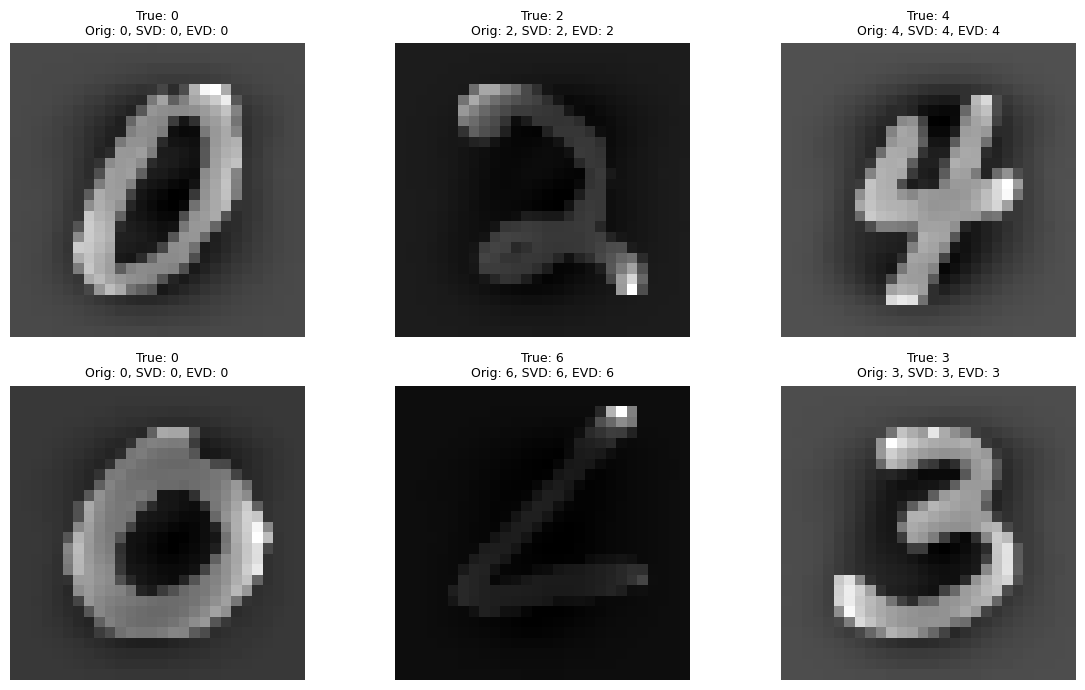

In [8]:
# --- Show MNIST Predictions Plot ---
if mnist_components["X_test_scaled"] is not None and mnist_components["y_test_true"] is not None:
    show_mnist_predictions(
        mnist_components["X_test_scaled"],
        mnist_components["y_test_true"],
        mnist_components["model_orig"],
        mnist_components["model_svd"],
        mnist_components["model_evd"],
        mnist_components["V_svd_transform"],
        mnist_components["eigvecs_evd_transform"]
    )
else:
    print("\nSkipping MNIST prediction visualization as MNIST data was not loaded/processed.")



In [1]:
import numpy as np
import pandas as pd
import time
from pathlib import Path
from typing import Tuple, Optional

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# ================================================================
# 1)  ---  CORE LINEAR-ALGEBRA HELPERS  ---------------------------
# ================================================================
def power_iteration_sym(A: np.ndarray,
                        num_iters: int = 1000,
                        tol: float = 1e-6) -> Tuple[float, np.ndarray]:
    """Return dominant eigenvalue/vector of *symmetric* A via power-iteration."""
    n = A.shape[0]
    v = np.random.randn(n)
    v /= np.linalg.norm(v)
    last_val = 0.0
    for _ in range(num_iters):
        w = A @ v
        lam = np.dot(v, w)
        v = w / np.linalg.norm(w)
        if abs(lam - last_val) < tol:
            break
        last_val = lam
    return lam, v


def quick_evd_linalg(C: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray]:
    """Top-k eigenvalues/vectors using `np.linalg.eigh` (C must be symmetric)."""
    eigvals, eigvecs = np.linalg.eigh(C)
    idx = np.argsort(eigvals)[::-1][:k]
    return eigvals[idx], eigvecs[:, idx]


def quick_svd_linalg(X: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Top-k SVD via `np.linalg.svd` (economy)."""
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    return U[:, :k], S[:k], Vt[:k, :]
def svd_from_scratch_eighLinalg(X):
    """
    Singular Value Decomposition from scratch using numpy.
    """
    # Calculate X^T * X
    XTX = X.T @ X

    # Eigen decomposition of X^T * X to get V
    eigenvalues_v, eigenvectors_v = np.linalg.eigh(XTX)
    
    # Sort them
    sorted_indices_v = np.argsort(eigenvalues_v)[::-1]
    singular_values_sq = eigenvalues_v[sorted_indices_v]
    V = eigenvectors_v[:, sorted_indices_v]

    # Calculate singular values
    singular_values = np.sqrt(singular_values_sq)
    
    # Create Sigma matrix
    Sigma = np.diag(singular_values)

    # Calculate U
    # U = A * V * Sigma_inv
    # To avoid division by zero for small singular values, we compute U directly
    U = []
    for i in range(len(singular_values)):
        if singular_values[i] > 1e-10: # A small threshold to handle floating point inaccuracies
            u_i = (X @ V[:, i]) / singular_values[i]
            U.append(u_i)
    
    U = np.array(U).T

    return U, singular_values, V.T

# ================================================================
# 2)  ---  HIGH-LEVEL REDUCTION FUNCTIONS  ------------------------
# ================================================================
def evd_reduce(X: np.ndarray,
               k: int,
               *,
               center: bool = True,
               use_linalg: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Reduce X (n_samples × n_features) to k dimensions via EVD/PCA.
    Returns (X_reduced, eigvecs, eigvals).
    """
    Xc = X - X.mean(axis=0) if center else X.copy()
    C = (Xc.T @ Xc) / (Xc.shape[0] - 1)  # covariance
    if use_linalg:
        eigvals, eigvecs = quick_evd_linalg(C, k)
    else:
        # fall back to power-iteration deflation
        eigvals = np.zeros(k)
        eigvecs = np.zeros((C.shape[0], k))
        C_work = C.copy()
        for i in range(k):
            lam, v = power_iteration_sym(C_work)
            eigvals[i] = lam
            eigvecs[:, i] = v
            C_work -= lam * np.outer(v, v)
    X_reduced = X @ eigvecs
    return X_reduced, eigvecs, eigvals


def svd_reduce(X: np.ndarray,
               k: int,
               *,
               use_linalg: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Reduce X to k dimensions via (truncated) SVD.
    Returns (X_reduced, U_k, S_k, Vt_k).
    """
    if use_linalg:
        U, S, Vt = quick_svd_linalg(X, k)
    else:
        # simple power-iteration SVD (costly for large k)  – demo only
        from copy import deepcopy
        A = deepcopy(X).astype(float)
        m, n = A.shape
        U = np.zeros((m, k))
        Vt = np.zeros((k, n))
        S = np.zeros(k)
        for i in range(k):
            # Right singular vector via power-iteration on AᵀA
            _, v = power_iteration_sym(A.T @ A)
            Av = A @ v
            sigma = np.linalg.norm(Av)
            u = Av / sigma
            U[:, i] = u
            Vt[i, :] = v
            S[i] = sigma
            A -= sigma * np.outer(u, v)
    X_reduced = U * S  # low-dim coords
    return X_reduced, U, S, Vt